[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_10/MISIS4825_Laboratorio10_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 10 – Taller: Segmentación de Imágenes con U-Net

## Introducción

Este taller abordará el problema de la **segmentación semántica**, que consiste en asignar a cada píxel de una imagen una etiqueta de clase. A diferencia de la detección de objetos, la segmentación ofrece un mapa preciso de las regiones de interés, con aplicaciones en:

- **Medicina**: delimitación de tumores o estructuras anatómicas en imágenes de resonancia magnética o tomografía computarizada.  
- **Agricultura de precisión**: identificación y cuantificación de cultivos y malezas en imágenes aéreas.  
- **Automoción**: segmentación de calzadas, vehículos y peatones en sistemas de conducción autónoma.  

La arquitectura **U-Net**, propuesta originalmente para segmentación biomédica en 2015, se caracteriza por su forma de "U": un **encoder** que extrae características de alto nivel y un **decoder** que recupera la resolución espacial, unidos mediante conexiones de salto (*skip connections*) para conservar detalle fino y contexto global.

## Objetivos

1. **Construir la arquitectura U-Net** desde cero:  
   - Definición del *encoder* (bloques convolucionales y operaciones de *pooling*).  
   - Definición del *decoder* (upsampling y concatenaciones con conexiones de salto).  
2. **Configurar el entrenamiento**: función de pérdida adecuada, optimizador y métricas.  
3. **Entrenar el modelo** y analizar las curvas de pérdida y métricas para identificar sobreajuste o subajuste.  
4. **Evaluar el rendimiento** de forma cuantitativa (IoU medio, precisión de píxel) y cualitativa (visualización de máscaras superpuestas).


**Datos**  
Se empleará el dataset **Oxford-IIIT Pet**, que incluye imágenes JPG de mascotas y máscaras PNG anotadas para 37 razas distintas.

- Descarga: https://www.robots.ox.ac.uk/~vgg/data/pets/  
- Formato: imágenes + máscaras con valores de clase por píxel

## 1. Descarga, preparación y preprocesamiento del dataset

En esta sección se carga **Oxford-IIIT Pet**, se redimensionan imágenes y máscaras, se normalizan los valores de píxel, se recodifican las máscaras de \{1,2,3\} a \{0,1,2\}, se expande el canal de las máscaras, y se crean los splits de entrenamiento, validación de prueba (70/15/15).

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import smart_resize
import numpy as np

In [2]:
# 1. Parámetros
BATCH_SIZE = 16
TARGET_SIZE = (160, 160)
N_CLASSES = 3

# 2. Generador con redimensionado, normalización y recodificación de máscaras
def pet_generator(split):
    """
    Lee Oxford-IIIT Pet v4 desde TFDS y devuelve lotes (X, Y) con:
      - X: imágenes float32 en [0,1], forma (batch, H, W, 3)
      - Y: máscaras uint8 en {0,1,2}, forma (batch, H, W, 1)
    """
    ds = tfds.load("oxford_iiit_pet:4.*.*", split=split, as_supervised=False)
    ds = ds.repeat().shuffle(1024)
    it = iter(tfds.as_numpy(ds))
    while True:
        batch_X, batch_Y = [], []
        for _ in range(BATCH_SIZE):
            sample = next(it)
            # Imagen: resize + normalización
            img = smart_resize(sample["image"], TARGET_SIZE).astype(np.float32) / 255.0
            # Máscara: resize + recodificar + expandir canal
            msk = smart_resize(sample["segmentation_mask"], TARGET_SIZE)
            mask = (msk[..., 0].astype(np.int32) - 1)[..., np.newaxis].astype(np.uint8)
            batch_X.append(img)
            batch_Y.append(mask)
        yield np.stack(batch_X), np.stack(batch_Y)

# 3. Splits 70% / 15% / 15%
TRAIN_SPLIT = "train+test[:70%]"
VAL_SPLIT   = "train+test[70%:85%]"
TEST_SPLIT  = "train+test[85%:]"

# 4. Crear generadores
train_gen = pet_generator(TRAIN_SPLIT)
val_gen   = pet_generator(VAL_SPLIT)
test_gen  = pet_generator(TEST_SPLIT)

# 5. Cálculo de pasos por época y conteo de muestras
_, info = tfds.load("oxford_iiit_pet:4.*.*", with_info=True)
n_total = info.splits["train"].num_examples + info.splits["test"].num_examples

steps_train = int((n_total * 0.70) // BATCH_SIZE)
steps_val   = int((n_total * 0.15) // BATCH_SIZE)
steps_test  = int((n_total * 0.15) // BATCH_SIZE)

n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

print(f"Total de muestras: {n_total}")
print(f"  Train (70%): {n_train}")
print(f"  Val   (15%): {n_val}")
print(f"  Test  (15%): {n_test}")
print(f"Pasos por época -> train: {steps_train}, val: {steps_val}, test: {steps_test}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.Y9AZR9_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.Y9AZR9_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Total de muestras: 7349
  Train (70%): 5144
  Val   (15%): 1102
  Test  (15%): 1103
Pasos por época -> train: 321, val: 68, test: 68


## 2. Exploración de Datos

Antes de entrenar el modelo, debemos revisar las imágenes para verificar su calidad y la precisión de las máscaras.

Las máscaras contienen las siguientes etiquetas:

- **0**: Fondo.  
- **1**: Mascota.  
- **2**: Borde. Esta etiqueta ayuda a la red a delimitar contornos con mayor precisión.

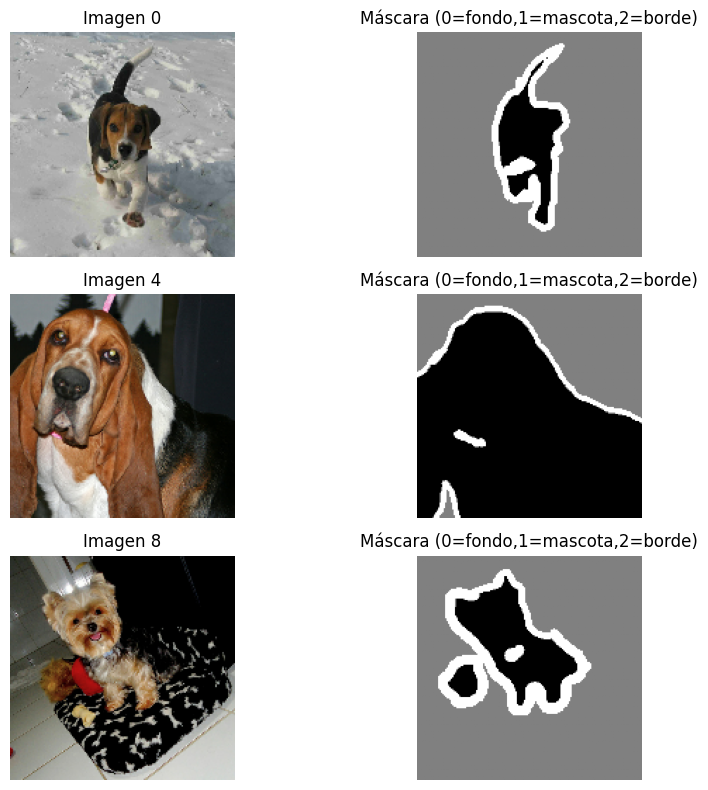

In [3]:
import matplotlib.pyplot as plt

# Obtener un lote de entrenamiento
x_batch, y_batch = next(train_gen)

# Seleccionar tres ejemplos dentro del lote
indices = [0, 4, 8]

plt.figure(figsize=(10, 8))
for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, 2, 2*i + 1)
    ax.imshow((x_batch[idx] * 255).astype("uint8"))
    ax.set_title(f"Imagen {idx}")
    ax.axis("off")

    # Máscara correspondiente
    ax = plt.subplot(3, 2, 2*i + 2)
    ax.imshow(y_batch[idx, ..., 0], cmap="gray")
    ax.set_title("Máscara (0=fondo,1=mascota,2=borde)")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 3 Arquitectura U-Net

La U-Net, presentada por Ronneberger et al. en 2015 en  **"U-Net: Convolutional Networks for Biomedical Image Segmentation"** ([ver paper](https://arxiv.org/abs/1505.04597)), consiste en dos caminos:

* **Encoder (contracción)**: captura contexto global mediante convoluciones y max-pooling.
* **Decoder (expansión)**: recupera resolución espacial y refina los contornos usando upsampling y concatenaciones con las capas del encoder (*skip connections*).

> A continuación se se presenta una ilustración de la arquitectura U-Net:
>
> ![U-Net Architecture](https://miro.medium.com/v2/resize:fit:1800/1*Rmo71TyPxvLLM4FnlH5MDg.jpeg)

In [4]:
from tensorflow.keras import layers, Model, Input

# Realiza dos convoluciones consecutivas con activación ReLU
def doble_conv(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)  # Primera convolución
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)  # Segunda convolución
    return x

# Bloque de descenso (encoder): reduce la resolución y extrae características
def encoder_block(x, filters):
    f = doble_conv(x, filters)         # Convoluciones
    p = layers.MaxPool2D(2)(f)         # Reducción de resolución
    p = layers.Dropout(0.2)(p)         # Regularización
    return f, p                        # Retorna características y salida reducida

# Bloque de ascenso (decoder): aumenta la resolución y combina características
def up_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)  # Upsampling
    x = layers.concatenate([x, skip])                                    # Conexión de salto
    x = layers.Dropout(0.2)(x)                                           # Regularización
    x = doble_conv(x, filters)                                           # Convoluciones
    return x

# Construcción de la U-Net
def build_unet(input_shape=(160, 160, 3), n_classes=3):
    inputs = Input(input_shape)  # Entrada del modelo

    # Encoder (menor profundidad y filtros reducidos)
    f1, c1 = encoder_block(inputs,  16)
    f2, c2 = encoder_block(c1,      32)
    f3, c3 = encoder_block(c2,      64)

    # Bottleneck
    b = doble_conv(c3, 128)

    # Decoder
    u1 = up_block(b,  f3, 64)
    u2 = up_block(u1, f2, 32)
    u3 = up_block(u2, f1, 16)

    # Capa de salida: mapa de segmentación con convolución 1×1
    outputs = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(u3)
    return Model(inputs, outputs)

# Crear y resumir el modelo
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 40,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 20,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 20,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 40, 40,    │     73,792 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 40,    │          0 │ conv2d_transpose

 Total params: 535,827 (2.04 MB)

 Trainable params: 535,827 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del modelo

En esta sección se compila la U-Net incluyendo, además de la exactitud, la métrica de **IoU medio**. Para la comparación con Dice, definimos una función auxiliar que se usará en la evaluación posterior.

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Métrica MeanIoU
class MeanIoUArgmax(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir probabilidades a etiquetas
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        # Quitar el canal extra de y_true
        y_true = tf.squeeze(y_true, axis=-1)
        return super().update_state(y_true, y_pred_labels, sample_weight)

# 2. Métrica Dice
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_ohe = tf.one_hot(tf.squeeze(y_true, -1), depth=N_CLASSES)
    y_pred_lbl = tf.one_hot(tf.argmax(y_pred, -1), depth=N_CLASSES)
    y_true_f = tf.reshape(y_true_ohe, [-1, N_CLASSES])
    y_pred_f = tf.reshape(y_pred_lbl, [-1, N_CLASSES])
    inter = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return tf.reduce_mean((2.*inter + smooth) / (union + smooth))

# 3. Callbacks para guardar el mejor modelo y detenerse temprano
callbacks = [
    ModelCheckpoint(
        'best_unet_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# 4. Compilación
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        MeanIoUArgmax(num_classes=N_CLASSES, name='mean_iou'),
        dice_coef
    ]
)

# 5. Entrenamiento
history = model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.4902 - dice_coef: 0.2449 - loss: 0.9801 - mean_iou: 0.1925 - val_accuracy: 0.6183 - val_dice_coef: 0.4540 - val_loss: 0.8296 - val_mean_iou: 0.3289
Epoch 2/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.6306 - dice_coef: 0.4866 - loss: 0.8221 - mean_iou: 0.3619 - val_accuracy: 0.6001 - val_dice_coef: 0.4426 - val_loss: 0.8502 - val_mean_iou: 0.3099
Epoch 3/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.6982 - dice_coef: 0.5783 - loss: 0.7191 - mean_iou: 0.4412 - val_accuracy: 0.7601 - val_dice_coef: 0.6516 - val_loss: 0.5900 - val_mean_iou: 0.5151
Epoch 4/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - accuracy: 0.7287 - dice_coef: 0.6284 - loss: 0.6610 - mean_iou: 0.4870 - val_accuracy: 0.7580 - val_dice_coef: 0.6560 - val_loss: 0.5979 - val_mean_iou: 0.5170
Epoch 5/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.7442 - dice_coef: 0.6517 - loss: 0.6271 - mean_iou: 0.5102 - va

## 6. Evaluación del modelo

1. Se evalúa el modelo en el conjunto de prueba para obtener pérdida, exactitud y IoU medio.

2. Se calcula el coeficiente Dice y la precisión de píxel en test.

In [6]:
# 6.0 Cargar el mejor modelo guardado
from tensorflow.keras.models import load_model

model = load_model(
    'best_unet_model.keras',
    custom_objects={
        'MeanIoUArgmax': MeanIoUArgmax,
        'dice_coef': dice_coef
    }
)

# 6.1 Evaluación cuantitativa
results = model.evaluate(
    test_gen,
    steps=steps_test,
    return_dict=True
)
print("Pérdida (test):     ", results['loss'])
print("Exactitud (test):   ", results['accuracy'])
print("Mean IoU (test):    ", results['mean_iou'])
print("Dice Coef (test):   ", results['dice_coef'])

# 6.2 Métricas personalizadas: precisión de píxel y Dice por clase
import numpy as np

smooth = 1e-6
class_dice = np.zeros(N_CLASSES, dtype=np.float32)
pixel_matches = 0
total_pixels = 0

# Recorrer todos los lotes de test
for _ in range(steps_test):
    x_b, y_b = next(test_gen)
    y_pred = model.predict(x_b, verbose=0)
    y_pred_lbl = np.argmax(y_pred, axis=-1)
    y_true_lbl = y_b[..., 0]

    pixel_matches += np.sum(y_pred_lbl == y_true_lbl)
    total_pixels += y_true_lbl.size

    # Acumular Dice por clase
    for cls in range(N_CLASSES):
        y_t = (y_true_lbl == cls).astype(np.float32).ravel()
        y_p = (y_pred_lbl == cls).astype(np.float32).ravel()
        inter = np.sum(y_t * y_p)
        union = np.sum(y_t) + np.sum(y_p)
        class_dice[cls] += (2 * inter + smooth) / (union + smooth)

pixel_acc = pixel_matches / total_pixels
dice_scores = class_dice / steps_test

print("Precisión de píxel:    ", pixel_acc)
print("Dice por clase:        ", dice_scores)
print("Dice medio:            ", dice_scores.mean())

68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.8633 - dice_coef: 0.7984 - loss: 0.3565 - mean_iou: 0.6854
Pérdida (test):      0.36664509773254395
Exactitud (test):    0.8597478270530701
Mean IoU (test):     0.6804074645042419
Dice Coef (test):    0.7946908473968506
Precisión de píxel:     0.8621950037339154
Dice por clase:         [0.8782045  0.90694535 0.60162807]
Dice medio:             0.7955926


## 7. Predicción / Inferencia

Visualizamos algunos ejemplos de test, comparando la imagen, la máscara real y la predicción, para apreciar la calidad de la segmentación.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


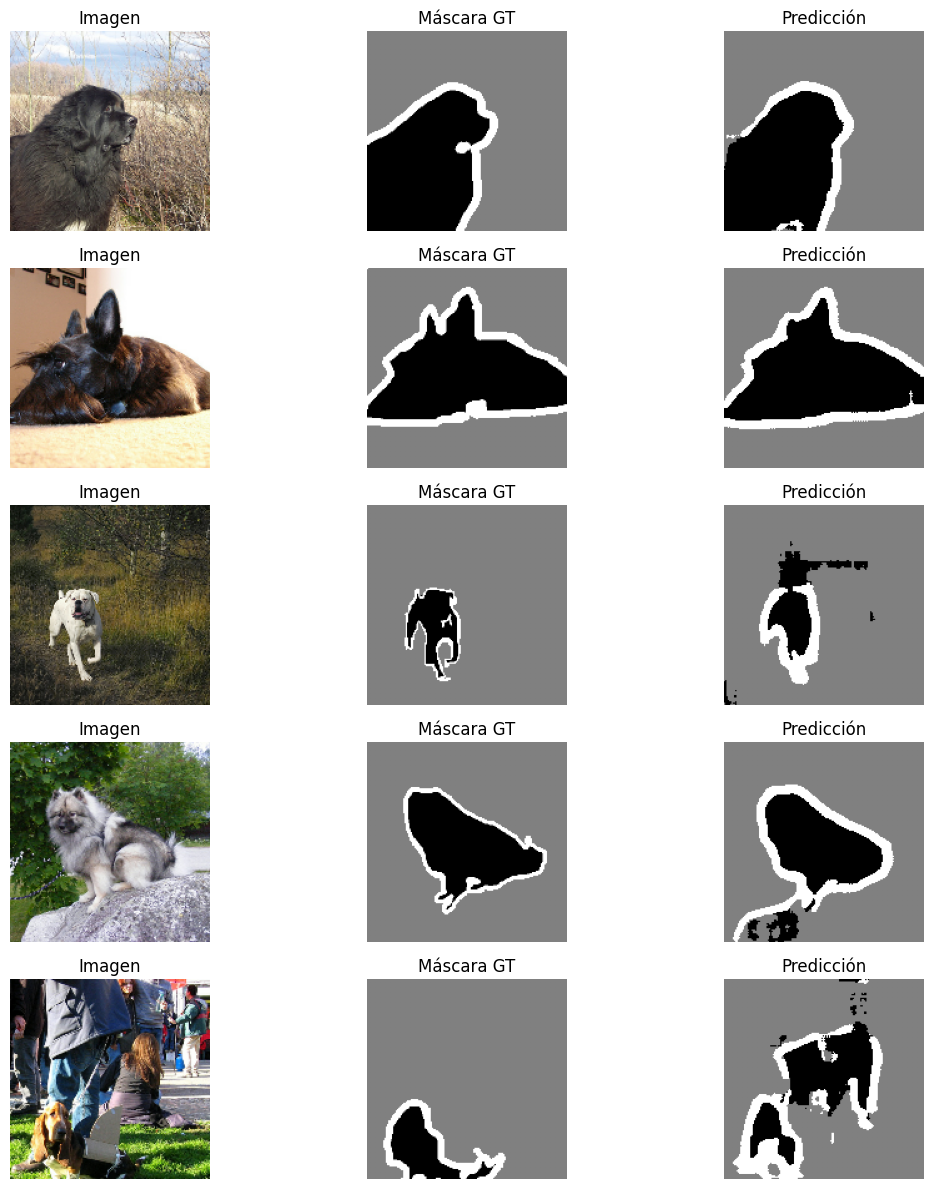

In [7]:
import matplotlib.pyplot as plt
import random

# Obtener un lote del generador de test
x_batch, y_batch = next(test_gen)

# Elegir 5 índices aleatorios dentro del batch
indices = random.sample(range(BATCH_SIZE), 5)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    img = x_batch[idx]
    ygt = y_batch[idx, ..., 0]
    ypr = np.argmax(model.predict(img[np.newaxis, ...]), axis=-1)[0]

    # Imagen original
    ax = plt.subplot(5, 3, 3*i + 1)
    ax.imshow((img * 255).astype('uint8'))
    ax.set_title('Imagen')
    ax.axis('off')

    # Máscara real
    ax = plt.subplot(5, 3, 3*i + 2)
    ax.imshow(ygt, cmap='gray')
    ax.set_title('Máscara GT')
    ax.axis('off')

    # Máscara predicha
    ax = plt.subplot(5, 3, 3*i + 3)
    ax.imshow(ypr, cmap='gray')
    ax.set_title('Predicción')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 8. Conclusiones y Discusión

Las siguientes preguntas constituyen el entregable de esta sección. Deben responderse directamente en este notebook, sustentando las respuestas con los resultados obtenidos y cualquier análisis relevante.

1. **Conexiones de salto (skip connections)**

   - Explicar por qué concatenar mapas del encoder con los del decoder conserva información espacial detallada.

2. **Profundidad y número de filtros**

   - Analizar el impacto de modificar la cantidad de bloques y filtros sobre la precisión y el costo computacional.

3. **Regularización**

   - Evaluar el efecto del `Dropout` y plantear otras técnicas para mejorar la generalización.

4. **Métricas de evaluación**

   - Comparar la rigurosidad y aplicabilidad de **IoU** frente a **coeficiente Dice** en distintos escenarios.

5. **Análisis de resultados y mejoras**

   - Identificar patrones de error (por ejemplo, en contornos o regiones pequeñas) y proponer extensiones de U-Net para optimización futura.
